# Train

In [1]:
%reload_ext autoreload
%autoreload 2

from langlearn.dataprep.utils import read_cows_train_tsv

data_prefix = './langlearn/data'
training_cows_tsv = data_prefix+'/raw/LangLearn_Training_Data/COWS-L2H/Train_COWS-L2H.tsv'

df,tsv_train = read_cows_train_tsv(training_cows_tsv)
df

,author,essay,sequence_abs
0,A_5693,5693,0
1,A_5693,8442,2
2,A_5693,9276,4
3,A_7790,7943,7
4,A_7790,8276,8
...,...,...,...
1421,A_1176,1176,4
1422,A_5399,5399,3
1423,A_5399,7682,4
1424,A_5831,8039,8


In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd


dtypes = defaultdict(np.float32, fn='str', predicted='category')

training_cows_malt = data_prefix + '/interim/LangLearn_Training_Data/COWS-L2H/malt.csv'

df_malt = pd.read_csv(training_cows_malt, sep=',', dtype=dtypes, keep_default_na=False)
df_malt['predicted'].replace(['B1', 'B2', 'C1', 'C2'], [1,2,3,4], inplace=True)
df_malt['predicted'] = df_malt['predicted'].astype(pd.CategoricalDtype(ordered=True))
df_malt.rename(columns={"fn":"essay"}, inplace=True)
df_malt['essay'] = df_malt['essay'].str.replace('.txt','')
df_malt.sort_values('essay', inplace=True, ignore_index=True)

from sklearn.feature_selection import VarianceThreshold
df_malt_vt = VarianceThreshold().set_output(transform='pandas')
df_malt_numbers = df_malt.select_dtypes('number').copy()
df_malt.drop(columns=df_malt_numbers.columns, inplace=True)
df_malt = pd.concat([df_malt, df_malt_vt.fit_transform(df_malt_numbers)], axis=1)

print(df_malt[df_malt.isna().any(axis=1)])
print(df_malt[df_malt.isnull().any(axis=1)])
print("#")
print(df_malt)

Empty DataFrame
Columns: [essay, predicted, probability_B1, probability_B2, probability_C1, scalarFeatures_Depth of the Parse Trees_0, scalarFeatures_Lexical Diversity_0, scalarFeatures_Maximal Non-Verbal Phrase - Mean_0, scalarFeatures_Maximal Non-Verbal Phrase - Std.Dev._0, scalarFeatures_Mean Length of Clauses (Tokens) - Mean_0, scalarFeatures_Non-Verbal Chains Length - Mean_0, scalarFeatures_Non-Verbal Chains Length - Std.Dev._0, scalarFeatures_Referential Cohesion - Mean_0, scalarFeatures_Referential Cohesion - Std.Dev._0, scalarFeatures_Sentence Length (in Tokens) - Mean_0, scalarFeatures_Sentence Length (in Tokens) - Std.Dev._0, scalarFeatures_Subordinate Ratio - Mean_0, scalarFeatures_Subordinate Ratio - Std.Dev._0, scalarFeatures_Text Length (in Lemmas)_0, scalarFeatures_Text Length (in Sentences)_0, scalarFeatures_Token Length - Mean_0, scalarFeatures_Token Length - Std.Dev._0, scalarFeatures_Verbal Roots_0, simpleScalarFeatures_Lunghezza del testo_0, simpleScalarFeatures_Lun

In [4]:
# spaCy - ES

import spacy
from spacy.lang.es.examples import sentences 

nlp = spacy.load("es_core_news_lg")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.morph, token.dep_)

Apple está buscando comprar una startup del Reino Unido por mil millones de dólares.
Apple Apple PROPN  nsubj
está estar AUX Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin aux
buscando buscar VERB VerbForm=Ger ROOT
comprar comprar VERB VerbForm=Inf xcomp
una uno DET Definite=Ind|Gender=Fem|Number=Sing|PronType=Art det
startup startup NOUN Gender=Fem|Number=Sing obj
del del ADP Definite=Def|Gender=Masc|Number=Sing|PronType=Art case
Reino Reino PROPN  nmod
Unido Unido PROPN  flat
por por ADP  case
mil mil NUM NumForm=Digit|NumType=Card nummod
millones millón NOUN Gender=Masc|Number=Plur nmod
de de ADP  case
dólares dólares NOUN NumForm=Digit nmod
. . PUNCT PunctType=Peri punct


In [3]:
import spacy
nlp = spacy.load("es_core_news_lg")

import langlearn.dataprep.utils
training_cows_essays_fn = data_prefix + '/interim/LangLearn_Training_Data/COWS-L2H/Essays_COWS-L2H.xml'
txts = langlearn.dataprep.utils.get_txts(training_cows_essays_fn, shrink_whitespaces=True)
docs = dict(zip(list(txts.keys()), list(nlp.pipe(list(txts.values())))))

testing_cows_essays_fn = data_prefix + '/interim/LangLearn_Test_Data/COWS-L2H/Essays_Test_COWS-L2H.xml'
txts_test = langlearn.dataprep.utils.get_txts(testing_cows_essays_fn, shrink_whitespaces=True)
docs.update(dict(zip(list(txts_test.keys()), list(nlp.pipe(list(txts_test.values()))))))

#list(txts.keys())
# ['9843',
# '7432',
# '2512',
# '3156',
# ...

#list(docs.items())
#[('9843',
#  Cuando pienso sobre una persona especial en mi vida, ...),
# ('7432',
#  Mi novia es muy importante en mi vida. Ella es muy ...),
# ('2512',
# ...

#type(list(docs.values())[0])
# spacy.tokens.doc.Doc

In [4]:
for key in set(txts).intersection(set(txts_test)):
    print(key)
    assert txts[key] == txts_test[key]

In [5]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from langlearn.dataprep.transformers import SpacyDocsPreprocessor

spacy_wf = Pipeline([
  ('wordform', SpacyDocsPreprocessor(docs=docs)),
  ("count", CountVectorizer(
    tokenizer=lambda x: x,
    token_pattern=None,
    preprocessor=lambda x: [tok.strip() for tok in x],
    lowercase=False,
    analyzer='word',
    ngram_range=(1, 3),
    min_df = 5,
    #min_df = 0.15,
    # max_features=500
  ))
], verbose=True)

spacy_lem = Pipeline([
  ('lemma', SpacyDocsPreprocessor(docs=docs, token_attribute='lemma_')),
  ("count", CountVectorizer(
    tokenizer=lambda x: x,
    token_pattern=None,
    preprocessor=lambda x: x,
    lowercase=False,
    analyzer='word',
    ngram_range=(1, 3),
    min_df = 5,
    #min_df = 0.2,
    #max_features=500
  ))
], verbose=True)

spacy_pos = Pipeline([
  ('pos', SpacyDocsPreprocessor(docs=docs, token_attribute='pos_')),
  ("count", CountVectorizer(
    tokenizer=lambda x: x,
    token_pattern=None,
    preprocessor=lambda x: x,
    lowercase=False,
    analyzer='word',
    ngram_range=(1, 3),
    min_df = 5,
    #min_df = 0.15,
    # max_features=500
  ))
], verbose=True)

spacy_dep = Pipeline([
  ('dep', SpacyDocsPreprocessor(docs=docs, token_attribute=None)),
  ("count", CountVectorizer(
    tokenizer=lambda x: x,
    token_pattern=None,
    preprocessor=lambda x: [f"{tok.dep_} {tok.head.dep_}" for tok in x],
    lowercase=False,
    analyzer='word',
    ngram_range=(1, 1),
  ))
], verbose=True)

spacy_morph = Pipeline([
  ('morph', SpacyDocsPreprocessor(docs=docs, token_attribute='morph')),
  ("count", CountVectorizer(
    token_pattern=r"\b[,=\w]+\b",
    preprocessor=lambda x: str([' '.join(str(tok).split('|')) for tok in x]),
    lowercase=False,
    analyzer='word',
    ngram_range=(1, 2),
  ))
], verbose=True)

#res = spacy_wf.fit_transform(docs.keys())
#for feature in spacy_wf.get_feature_names_out()[0:150]:
#  print(feature)

In [6]:
print(df)
docs['5693']

      author essay  sequence_abs
0     A_5693  5693             0
1     A_5693  8442             2
2     A_5693  9276             4
3     A_7790  7943             7
4     A_7790  8276             8
...      ...   ...           ...
1421  A_1176  1176             4
1422  A_5399  5399             3
1423  A_5399  7682             4
1424  A_5831  8039             8
1425  A_5831  5831            10

[1426 rows x 3 columns]



Angelina Jolie es mi actriz favorita. Angelina Jolie es actriz americana y ella es de Los Angeles, California.  Ella es muy inteligente y sympática. Ella es muy guapa tambíen.  Ella tiene el pelo castaño y ella tiene los ojas verdes o azules.  Ella es delgada y alta. Ella tiene cuarenta y uno años y ella tiene muchos hijos con Brad Pitt. Ella tiene tres hijas y tres hijos.  Sus hijas son Zahara, Shiloh, y Vivenne Jolie-Pitt y sus hijos son Maddox, Pax, y Knox Jolie-Pitt.  Ella viaja y ella ayuda con el trabajo humanitario.  Ella ayuda con la organización UNHCR y ella ayuda con la educación de los niños.  Ella ayuda las mujeres y las niñas tambíen.  Angelina Jolie es una persona muy buena en el mundo y ella tiene buenos principios.
Ella es una muy buena actriz y sus películas son muy buenas.  Á mi me gusta las películas “Mr. and Mrs. Smith”, “Maleficent”, y “Lara Croft” porque me gusta las películas de acción y fantasía.  Mi madre le gusta Angelina Jolie también.  Miré las películas de

In [7]:
df_full = pd.merge(df, df_malt, how='outer', on='essay')
df_full['author'] = df_full["author"].astype('category')
#df_full['essay'] = df_full["essay"].astype('category')

y = df_full['sequence_abs'].copy()
#y = y.astype(pd.CategoricalDtype(ordered=True))
#y = y.astype(int)
X = df_full.drop(columns='sequence_abs')

#df_full

print(df_full[df_full.isna().any(axis=1)])
print(df_full[df_full.isnull().any(axis=1)])

df_full

Empty DataFrame
Columns: [author, essay, sequence_abs, predicted, probability_B1, probability_B2, probability_C1, scalarFeatures_Depth of the Parse Trees_0, scalarFeatures_Lexical Diversity_0, scalarFeatures_Maximal Non-Verbal Phrase - Mean_0, scalarFeatures_Maximal Non-Verbal Phrase - Std.Dev._0, scalarFeatures_Mean Length of Clauses (Tokens) - Mean_0, scalarFeatures_Non-Verbal Chains Length - Mean_0, scalarFeatures_Non-Verbal Chains Length - Std.Dev._0, scalarFeatures_Referential Cohesion - Mean_0, scalarFeatures_Referential Cohesion - Std.Dev._0, scalarFeatures_Sentence Length (in Tokens) - Mean_0, scalarFeatures_Sentence Length (in Tokens) - Std.Dev._0, scalarFeatures_Subordinate Ratio - Mean_0, scalarFeatures_Subordinate Ratio - Std.Dev._0, scalarFeatures_Text Length (in Lemmas)_0, scalarFeatures_Text Length (in Sentences)_0, scalarFeatures_Token Length - Mean_0, scalarFeatures_Token Length - Std.Dev._0, scalarFeatures_Verbal Roots_0, simpleScalarFeatures_Lunghezza del testo_0, si

,author,essay,sequence_abs,predicted,probability_B1,probability_B2,probability_C1,scalarFeatures_Depth of the Parse Trees_0,scalarFeatures_Lexical Diversity_0,scalarFeatures_Maximal Non-Verbal Phrase - Mean_0,...,simpleDistrFeatures_Distribuzione dell'astrattezza/concretezza_Astrattezza_0,simpleDistrFeatures_Distribuzione dell'astrattezza/concretezza_Semiastrattezza_0,simpleDistrFeatures_Distribuzione dell'astrattezza/concretezza_Concretezza_0,simpleDistrFeatures_Sofisticatezza lessicale_parole vuote_0,simpleDistrFeatures_Sofisticatezza lessicale_lemmi vuoti_0,simpleDistrFeatures_Sofisticatezza lessicale_parole contenuto_0,simpleDistrFeatures_Sofisticatezza lessicale_lemmi contenuto_0,simpleDistrFeatures_Tasso di vocabolario di base_Fondamentali_0,simpleDistrFeatures_Tasso di vocabolario di base_Alto uso_0,simpleDistrFeatures_Tasso di vocabolario di base_Alto disponibilità_0
0,A_5693,5693,0,1,0.518244,0.326842,0.154914,7.0,0.28362,6.863636,...,0.000000,0.222222,0.777778,0.002926,0.013518,0.000036,0.001183,0.809524,0.142857,0.047619
1,A_5693,8442,2,1,0.518244,0.326842,0.154914,7.0,0.27289,5.062500,...,0.000000,0.000000,1.000000,0.008125,0.021195,0.000024,0.000119,0.888889,0.111111,0.000000
2,A_5693,9276,4,1,0.518244,0.326842,0.154914,7.0,0.31675,5.884615,...,0.090909,0.363636,0.545455,0.005943,0.016836,0.000046,0.000974,0.766667,0.233333,0.000000
3,A_7790,7943,7,1,0.518245,0.326844,0.154911,7.0,0.38506,4.750000,...,0.000000,0.375000,0.625000,0.004073,0.015157,0.000029,0.000094,0.781250,0.187500,0.031250
4,A_7790,8276,8,1,0.518211,0.326858,0.154932,7.0,0.35810,8.047619,...,0.000000,0.375000,0.625000,0.006694,0.014500,0.000056,0.001197,0.928571,0.071429,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,A_1176,1176,4,1,0.518229,0.326830,0.154941,7.0,0.41820,5.809524,...,0.000000,0.100000,0.900000,0.005965,0.016484,0.000081,0.000840,0.787879,0.212121,0.000000
1422,A_5399,5399,3,1,0.518245,0.326843,0.154913,14.0,0.32100,11.071428,...,0.000000,0.000000,1.000000,0.004446,0.013292,0.000051,0.000913,0.851852,0.111111,0.037037
1423,A_5399,7682,4,1,0.518244,0.326842,0.154914,9.0,0.32346,7.000000,...,0.000000,0.444444,0.555556,0.004047,0.017892,0.000054,0.000937,0.920000,0.080000,0.000000
1424,A_5831,8039,8,1,0.518244,0.326842,0.154914,13.0,0.35539,9.250000,...,0.090909,0.090909,0.818182,0.004506,0.016497,0.000152,0.001389,0.935484,0.032258,0.032258


In [9]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn import svm
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectPercentile, chi2, VarianceThreshold, mutual_info_regression, SelectKBest, mutual_info_classif, f_regression, r_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV, GroupKFold
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from langlearn.dataprep.pipes import sklearn_pipe
from langlearn.dataprep.transformers import GroupNormalizer

#df_full_scaled = gn.transform(df_full.iloc[0:100, :])
#df_full_scaled = gn.transform(df_full)

pipe = sklearn_pipe(X, verbose=True)
spacy_fu = FeatureUnion(transformer_list=[
        ('spacy_wf', spacy_wf),
        #('spacy_lem', spacy_wf),
        ('spacy_pos', spacy_pos),
        ('spacy_dep', spacy_dep),
        ('spacy_morph', spacy_morph),
    ], verbose=True)

spacy_pipe = ColumnTransformer([
        ('spacy_pipe', spacy_fu, 'essay'),
    ],
    remainder='drop',
    n_jobs=1, 
    verbose=True
)

gn_pipe = Pipeline([
    ('fu', FeatureUnion([
        ('ct_passthrough_author', ColumnTransformer([
            ('passthrough', 'passthrough', ['author'])
            ], remainder='drop', verbose=True)
        ),
        ('ct_passthrough_numbers', ColumnTransformer([
                ('passthrough', 'passthrough', make_column_selector(dtype_include='number')),
            ], remainder='drop', verbose=True)
        ),
        ], verbose=True)
    ),
    ('gn', GroupNormalizer())
], verbose=True).set_output(transform='pandas')

combined_features = FeatureUnion([
    ("pipe", pipe),
    ('gn', gn_pipe),
    ('spacy', spacy_pipe),
    ],
    verbose=True
)

scoring = ['neg_mean_absolute_error', 'explained_variance', 'r2']

Categorical columns are: ['author']
Ordinal columns are: ['predicted']
Numerical columns are: ['probability_B1', 'probability_B2', 'probability_C1', 'scalarFeatures_Depth of the Parse Trees_0', 'scalarFeatures_Lexical Diversity_0', 'scalarFeatures_Maximal Non-Verbal Phrase - Mean_0', 'scalarFeatures_Maximal Non-Verbal Phrase - Std.Dev._0', 'scalarFeatures_Mean Length of Clauses (Tokens) - Mean_0', 'scalarFeatures_Non-Verbal Chains Length - Mean_0', 'scalarFeatures_Non-Verbal Chains Length - Std.Dev._0', 'scalarFeatures_Referential Cohesion - Mean_0', 'scalarFeatures_Referential Cohesion - Std.Dev._0', 'scalarFeatures_Sentence Length (in Tokens) - Mean_0', 'scalarFeatures_Sentence Length (in Tokens) - Std.Dev._0', 'scalarFeatures_Subordinate Ratio - Mean_0', 'scalarFeatures_Subordinate Ratio - Std.Dev._0', 'scalarFeatures_Text Length (in Lemmas)_0', 'scalarFeatures_Text Length (in Sentences)_0', 'scalarFeatures_Token Length - Mean_0', 'scalarFeatures_Token Length - Std.Dev._0', 'scalarF

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import FunctionTransformer
from langlearn.dataprep.transformers import GroupNormalizer

stdscaler = StandardScaler() # with_mean=False)

#pca = PCA(100)
pca = TruncatedSVD(n_components=125)

dtregressor = DecisionTreeRegressor(random_state=42)
hgbreg = HistGradientBoostingRegressor(loss='squared_error')
svmreg = svm.SVR(kernel="rbf", C=1e1, gamma=0.1) #, C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
krreg = KernelRidge(kernel='rbf')


estimators = [svmreg, hgbreg, krreg]

In [11]:
#X_in = X.iloc[0:15, :]
#y_in = y[0:15]
#
X_in = X.copy()
y_in = y.copy()

proc_pipe = Pipeline(steps=[
    ('combined_features', combined_features),
    ('to_dense', FunctionTransformer(lambda x: np.asarray(x.todense()), accept_sparse=True)),
    ('scaler_std', stdscaler),
    ('redux_pca', pca),
    ('estimator_svmreg', estimators[1])
], verbose=True)

y_in

0        0
1        2
2        4
3        7
4        8
        ..
1421     4
1422     3
1423     4
1424     8
1425    10
Name: sequence_abs, Length: 1426, dtype: int64

In [12]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

scores = cross_validate(proc_pipe, X_in, y_in, cv=KFold(n_splits=3, shuffle=True, random_state=24), scoring=scoring, n_jobs=1, verbose=True, error_score='raise')
print(scores)
for score in scores:
    print(f"{score}: {scores[score].mean()} {scores[score].std()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........... (step 1 of 1) Processing encoder, total=   0.0s
[ColumnTransformer] ........... (1 of 3) Processing cat, total=   0.0s
[Pipeline] ........... (step 1 of 1) Processing encoder, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ord, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (3 of 3) Processing num, total=   0.0s
[FeatureUnion] .......... (step 1 of 3) Processing pipe, total=   0.0s
[ColumnTransformer] ... (1 of 1) Processing passthrough, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing ct_passthrough_author, total=   0.0s
[ColumnTransformer] ... (1 of 1) Processing passthrough, total=   0.0s
[FeatureUnion]  (step 2 of 2) Processing ct_passthrough_numbers, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing fu, total=   0.0s
GN.fit: (950, 152)
ct_passthrough_author__passthrough__author


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min finished


SVR(kernel='poly') for combined


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] .......... (step 3 of 3) Processing selector, total=   0.0s
[ColumnTransformer] ........... (1 of 1) Processing num, total=   0.1s
[FeatureUnion] .......... (step 1 of 2) Processing pipe, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing wordform, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing count, total=   0.5s
[FeatureUnion] ...... (step 1 of 5) Processing spacy_wf, total=   0.6s
[Pipeline] .......... (step 1 of 2) Processing wordform, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing count, total=   0.5s
[FeatureUnion] ..... (step 2 of 5) Processing spacy_lem, total=   0.6s
[Pipeline] ............... (step 1 of 2) Processing pos, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing count, total=   0.2s
[FeatureUnion] ..... (step 3 of 5) Processing spacy_pos, total=   0.2s
[Pipel

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([37.29676533, 35.66477418, 40.82460666]), 'score_time': array([1.01504469, 1.25631618, 1.27695346]), 'test_neg_mean_absolute_error': array([-2.55437316, -2.52721662, -2.43532519]), 'test_explained_variance': array([0.42269936, 0.36672103, 0.38807427]), 'test_r2': array([0.41981183, 0.33791598, 0.37883409])}
test_neg_mean_absolute_error: -2.5056  0.0509
test_explained_variance     :  0.3925  0.0231
test_r2                     :  0.3789  0.0334
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.2s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] .......... (step 3 of 3) Processing selector, total=   0.0s
[ColumnTransformer] ........... (1 of 1) Processing num, total=   0.2s
[FeatureUnion] .......... (step 1 of 2) Processing pipe, total=   0.2s
[Pipeline] .......... (step 1 of 2) Processing wordform, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing count, total=   0.5s
[FeatureUnion] ...... (step 1 of 5) P

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.7min finished


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  1  7 14 21 18  7  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  4 11 24 25 31  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 11 25 25 49  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  3  5 18 26 26  7  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  6 58 56 27 15  2  1  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  4 36 94 47 13  5  1  3  2  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  1 19 44 49 19  2  2  0  0  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  9 29 26  8  2  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  2

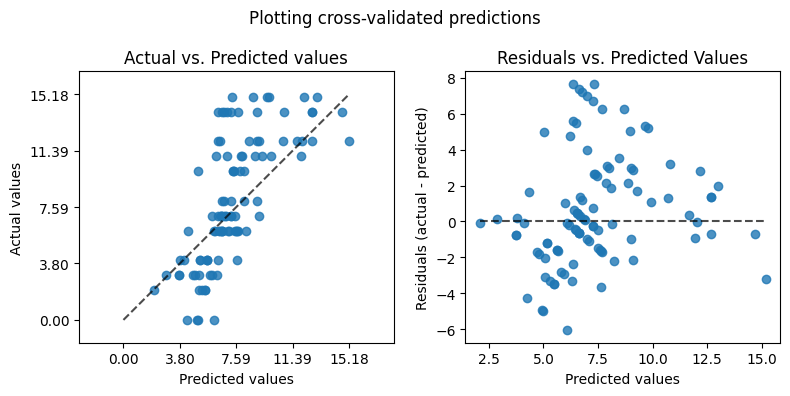

####



In [11]:
import sklearn.metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

X_in = X.copy()
y_in = y.copy()

for estimator in estimators[1:2]:

    for processor, preprocessor_name, _X, _y in [(proc_pipe, 'preproc_pipe', X_in, y_in)]:
        print(f'{estimator} for {preprocessor_name}')
        
        # scores = cross_validate(make_pipeline(preprocessor, estimator), X, y, return_estimator=True, cv=10, scoring=scoring, n_jobs=-1)
        scores = cross_validate(processor, _X.copy(), _y.copy(), return_estimator=False, groups=_X['author'], 
                                cv=GroupKFold(n_splits=3), scoring=scoring, n_jobs=1, error_score='raise', verbose=True)
        print(scores)
        score_maxlength = max([len(score) for score in scores if score.startswith('test_')])
        for score in [score for score in scores if score.startswith('test_')]:
            print(f"{score: <{score_maxlength}}: {scores[score].mean(): .4f} {scores[score].std(): .4f}")
                
        #y_preds = list()
        #for trained_esimator in scores['estimator']:
        #    y_preds.extend(cross_val_predict(trained_esimator, X, y, groups=X['author'], cv=GroupKFold(n_splits=10), n_jobs=-1))
        y_pred = cross_val_predict(processor, _X.copy(), _y.copy(), groups=_X['author'], 
                                   cv=GroupKFold(n_splits=3), n_jobs=1, verbose=True)
        #print(y_pred)
        # print(np.array(y_preds).round(0).astype(int))
        print(sklearn.metrics.confusion_matrix(_y, y_pred.round(0).astype(int)))

        import matplotlib.pyplot as plt
        from sklearn.metrics import PredictionErrorDisplay

        fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
        PredictionErrorDisplay.from_predictions(
            _y,
            y_pred=y_pred,
            kind="actual_vs_predicted",
            #subsample=250,
            ax=axs[0],
            random_state=0,
        )
        axs[0].set_title("Actual vs. Predicted values")
        
        PredictionErrorDisplay.from_predictions(
            _y,
            y_pred=y_pred,
            kind="residual_vs_predicted",
            #subsample=250,
            ax=axs[1],
            random_state=0,
        )
        axs[1].set_title("Residuals vs. Predicted Values")
        
        fig.suptitle("Plotting cross-validated predictions")
        plt.tight_layout()
        plt.show()
        
        print('####\n')
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html

In [36]:
#local_pipe.fit(X_in, y_in)


[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] .......... (step 3 of 3) Processing selector, total=   0.0s
[ColumnTransformer] ........... (1 of 1) Processing num, total=   0.1s
[FeatureUnion] .......... (step 1 of 2) Processing pipe, total=   0.2s
[Pipeline] .......... (step 1 of 2) Processing wordform, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing count, total=   0.9s
[FeatureUnion] ...... (step 1 of 5) Processing spacy_wf, total=   1.0s
[Pipeline] .......... (step 1 of 2) Processing wordform, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing count, total=   0.9s
[FeatureUnion] ..... (step 2 of 5) Processing spacy_lem, total=   1.0s
[Pipeline] ............... (step 1 of 2) Processing pos, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing count, total=   0.3s
[FeatureUnion] ..... (step 3 of 5) Processing spacy_pos, total=   0.4s
[Pipel

Pipeline(steps=[('combined_features',
                 FeatureUnion(transformer_list=[('pipe',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler()),
                                                                                                  ('selector',
                                                                                                   VarianceThreshold())],
                                                                                           verbose=True),
                                                                                  ['probability_B1',
                                                                                   'probability_B2',
                                                                                   'probability_C1',
                                                                                   'probability_C2',
                                                                                   'scalarFeatures_Depth '
                                                                                   'of '
                                                                                   'th...
                                                                                                                                                               '1151': Un día, yo me levanté y quise lavar mi pelo porque fue sucio y el color fue desvanecimiento a verde y no más azul. Pero, también quise esperar hasta luego porque necesité mi tinte para el caballo azul que pedí una semana pasada. No estuve seguro si llegará este dia, y por eso, yo fui a una tienda que es cerca para comprar un tinte para el caballo nuevo. Cuando volví a mi dormitorio, me bañé. Fue un momento terrible porque el color de mi tinte para el caballo salpicó en todos los lugares en el baño. El color fue muy permanente y no pude lo retirar. Tuve miedo y no supe que hacer despues este momento.  Trate de limpiar tanto como pude, pero fue fracasado. Entonces, fui a mi cuarto y envíe una correo electronico a mi asesor residencial. La dije que yo manché el baño y la preguntó si me cobraran por el accidente. Ella estuvo muy simpática y me dijo que hablara con alguien sobre la situación. Después de un or dos horas, yo recibí un correo electrónico de la oficina como el mensaje: "Tienes un paquete en la oficina; recogerlo ahora por favor." El día empeoró porque el paquete fue mi tinte para el caballo que estaba esperando. Estuve triste porque el baño fue manchado con el tinte azul. También, cuando mi pelo estaba seco, el color fue feo. No me gusta el color porque no coincide con el color en la caja. Estuve enojada en este momento porque hubo tantas cosas que salieron mal que podría resolverse si acabo de esperar., ...},
                                                                                                                                                         token_attribute='morph')),
                                                                                                                                  ('count',
                                                                                                                                   CountVectorizer(lowercase=False,
                                                                                                                                                   ngram_range=(1,
                                                            

In [32]:
#local_pipe.score(X_in, y_in)

0.4708780135319408

# Predict

In [13]:
testing_cows_tsv = data_prefix+'/raw/LangLearn_Test_Data/COWS-L2H/Test_COWS-L2H.tsv'
df_test,tsv_test = read_cows_train_tsv(testing_cows_tsv)
df_test

,author,essay,sequence_abs
0,A_1707,1707,2
1,A_1707,4765,3
2,A_3115,3115,2
3,A_3115,3256,4
4,A_1066,1066,6
...,...,...,...
583,A_1275,9366,8
584,A_4647,4647,7
585,A_4647,5194,8
586,A_1301,1301,7


In [14]:
from collections import defaultdict

import numpy as np
import pandas as pd


dtypes = defaultdict(np.float32, fn='str', predicted='category')

testing_cows_malt = data_prefix + '/interim/LangLearn_Test_Data/COWS-L2H/malt.csv'

df_malt_test = pd.read_csv(testing_cows_malt, sep=',', dtype=dtypes, keep_default_na=False)
df_malt_test['predicted'].replace(['B1', 'B2', 'C1', 'C2'], [1,2,3,4], inplace=True)
df_malt_test['predicted'] = df_malt_test['predicted'].astype(pd.CategoricalDtype(ordered=True))
df_malt_test.rename(columns={"fn":"essay"}, inplace=True)
df_malt_test['essay'] = df_malt_test['essay'].str.replace('.txt','')
df_malt_test.sort_values('essay', inplace=True, ignore_index=True)

df_malt_test_numbers = df_malt_test.select_dtypes('number').copy()
df_malt_test.drop(columns=df_malt_test_numbers.columns, inplace=True)
df_malt_test = pd.concat([df_malt_test, df_malt_vt.transform(df_malt_test_numbers)], axis=1)

print(df_malt_test[df_malt_test.isna().any(axis=1)])
print(df_malt_test[df_malt_test.isnull().any(axis=1)])
print("#")
print(df_malt_test)

Empty DataFrame
Columns: [essay, predicted, probability_B1, probability_B2, probability_C1, scalarFeatures_Depth of the Parse Trees_0, scalarFeatures_Lexical Diversity_0, scalarFeatures_Maximal Non-Verbal Phrase - Mean_0, scalarFeatures_Maximal Non-Verbal Phrase - Std.Dev._0, scalarFeatures_Mean Length of Clauses (Tokens) - Mean_0, scalarFeatures_Non-Verbal Chains Length - Mean_0, scalarFeatures_Non-Verbal Chains Length - Std.Dev._0, scalarFeatures_Referential Cohesion - Mean_0, scalarFeatures_Referential Cohesion - Std.Dev._0, scalarFeatures_Sentence Length (in Tokens) - Mean_0, scalarFeatures_Sentence Length (in Tokens) - Std.Dev._0, scalarFeatures_Subordinate Ratio - Mean_0, scalarFeatures_Subordinate Ratio - Std.Dev._0, scalarFeatures_Text Length (in Lemmas)_0, scalarFeatures_Text Length (in Sentences)_0, scalarFeatures_Token Length - Mean_0, scalarFeatures_Token Length - Std.Dev._0, scalarFeatures_Verbal Roots_0, simpleScalarFeatures_Lunghezza del testo_0, simpleScalarFeatures_Lun

In [18]:
#df_ctap_test['essay']
# Name: essay, Length: 468, dtype: objec
#df_malt_test['essay']
# Name: essay, Length: 471, dtype: object

In [27]:
#import spacy
#nlp = spacy.load("es_core_news_lg")

import langlearn.dataprep.utils
testing_cows_essays_fn = data_prefix + '/interim/LangLearn_Test_Data/COWS-L2H/Essays_Test_COWS-L2H.xml'

txts_test = langlearn.dataprep.utils.get_txts(testing_cows_essays_fn, shrink_whitespaces=True)
docs.update(dict(zip(list(txts_test.keys()), list(nlp.pipe(list(txts_test.values()))))))

In [39]:
docs['1707']

La persona famosa que quiero hablar es de Kylie Jenner y su bebé.  El padre del bebé con Kylie es otro famoso rapero nombre Travis Scott. Ambos son muy jovenes. Kylie no le dijo a nadie que estaba embarazada porque quería que fuera privada y la respeto tanto por eso. SI usted no sabe Kylie Jenner, ella tiene su propio maquillaje marca y tiene la nombre de "Kylie." Ella vende paletas de sombras, lápices labiales, lipglosses y relatadores. Ella tiene veinte años y Travis Scott tiene veinticinco años. Su bebé es la niña y se nombre es Stormi. Es el primer bebé que ambos han tenido y son super felices. Todo el tiempo siempre estaba hablando de Kylie estar embarazada y tratando de ocultarlo, pero me gustó que ella hizo que como algo personal como que no debe ser utilizado una cosa personal para llegar a ser más famoso. Su familia entera es también muy famosa y está siempre en las noticias y las revistas. En la Kardashian familiares es otra razón aunque también. Toda su familia tiene su prop

In [15]:
df_full_test = pd.merge(df_test, df_malt_test, how='outer', on='essay')
df_full_test['author'] = df_full_test["author"].astype('category')
#df_full['essay'] = df_full["essay"].astype('category')

X_test = df_full_test.drop(columns='sequence_abs')
#df_full

print(df_full_test[df_full_test.isna().any(axis=1)])
print(df_full_test[df_full_test.isnull().any(axis=1)])

X_test

Empty DataFrame
Columns: [author, essay, sequence_abs, predicted, probability_B1, probability_B2, probability_C1, scalarFeatures_Depth of the Parse Trees_0, scalarFeatures_Lexical Diversity_0, scalarFeatures_Maximal Non-Verbal Phrase - Mean_0, scalarFeatures_Maximal Non-Verbal Phrase - Std.Dev._0, scalarFeatures_Mean Length of Clauses (Tokens) - Mean_0, scalarFeatures_Non-Verbal Chains Length - Mean_0, scalarFeatures_Non-Verbal Chains Length - Std.Dev._0, scalarFeatures_Referential Cohesion - Mean_0, scalarFeatures_Referential Cohesion - Std.Dev._0, scalarFeatures_Sentence Length (in Tokens) - Mean_0, scalarFeatures_Sentence Length (in Tokens) - Std.Dev._0, scalarFeatures_Subordinate Ratio - Mean_0, scalarFeatures_Subordinate Ratio - Std.Dev._0, scalarFeatures_Text Length (in Lemmas)_0, scalarFeatures_Text Length (in Sentences)_0, scalarFeatures_Token Length - Mean_0, scalarFeatures_Token Length - Std.Dev._0, scalarFeatures_Verbal Roots_0, simpleScalarFeatures_Lunghezza del testo_0, si

,author,essay,predicted,probability_B1,probability_B2,probability_C1,scalarFeatures_Depth of the Parse Trees_0,scalarFeatures_Lexical Diversity_0,scalarFeatures_Maximal Non-Verbal Phrase - Mean_0,scalarFeatures_Maximal Non-Verbal Phrase - Std.Dev._0,...,simpleDistrFeatures_Distribuzione dell'astrattezza/concretezza_Astrattezza_0,simpleDistrFeatures_Distribuzione dell'astrattezza/concretezza_Semiastrattezza_0,simpleDistrFeatures_Distribuzione dell'astrattezza/concretezza_Concretezza_0,simpleDistrFeatures_Sofisticatezza lessicale_parole vuote_0,simpleDistrFeatures_Sofisticatezza lessicale_lemmi vuoti_0,simpleDistrFeatures_Sofisticatezza lessicale_parole contenuto_0,simpleDistrFeatures_Sofisticatezza lessicale_lemmi contenuto_0,simpleDistrFeatures_Tasso di vocabolario di base_Fondamentali_0,simpleDistrFeatures_Tasso di vocabolario di base_Alto uso_0,simpleDistrFeatures_Tasso di vocabolario di base_Alto disponibilità_0
0,A_1707,1707,1,0.517825,0.327680,0.154494,11.0,0.36700,7.555555,5.833193,...,0.100000,0.500000,0.400000,0.004417,0.014546,0.000249,0.001245,0.933333,0.066667,0.000000
1,A_1707,4765,1,0.518137,0.326945,0.154919,8.0,0.38505,6.571429,4.749436,...,0.090909,0.272727,0.636364,0.004046,0.019082,0.000058,0.000913,0.870968,0.096774,0.032258
2,A_3115,3115,1,0.518244,0.326842,0.154914,5.0,0.40000,3.250000,1.752549,...,0.000000,0.500000,0.500000,0.002656,0.025502,0.000012,0.001939,0.888889,0.111111,0.000000
3,A_3115,3256,1,0.518245,0.326842,0.154914,7.0,0.36736,5.080000,3.581434,...,0.000000,0.000000,1.000000,0.003223,0.015389,0.000041,0.001195,0.840000,0.160000,0.000000
4,A_1066,1066,1,0.518244,0.326842,0.154914,7.0,0.30284,7.322581,5.179364,...,0.000000,0.166667,0.833333,0.010928,0.019189,0.000004,0.000075,0.761905,0.190476,0.047619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,A_1275,9366,1,0.518244,0.326842,0.154914,7.0,0.33856,3.794118,2.782841,...,0.111111,0.000000,0.888889,0.002902,0.016700,0.000040,0.000795,0.718750,0.218750,0.062500
584,A_4647,4647,1,0.518269,0.326851,0.154880,6.0,0.39387,2.585366,1.431356,...,0.000000,0.000000,1.000000,0.004891,0.012895,0.000069,0.000943,0.785714,0.142857,0.071429
585,A_4647,5194,1,0.518244,0.326842,0.154914,6.0,0.30844,3.622222,2.166783,...,0.000000,0.200000,0.800000,0.007457,0.017768,0.000075,0.001221,0.954545,0.045455,0.000000
586,A_1301,1301,1,0.518263,0.327008,0.154730,6.0,0.46765,3.302325,1.611490,...,0.285714,0.428571,0.285714,0.007415,0.017330,0.000092,0.000979,0.878788,0.060606,0.060606


In [16]:
proc_pipe.fit(X_in, y_in)

y_pred = proc_pipe.predict(X_test)

[Pipeline] ........... (step 1 of 1) Processing encoder, total=   0.1s
[ColumnTransformer] ........... (1 of 3) Processing cat, total=   0.1s
[Pipeline] ........... (step 1 of 1) Processing encoder, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ord, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (3 of 3) Processing num, total=   0.0s
[FeatureUnion] .......... (step 1 of 3) Processing pipe, total=   0.2s
[ColumnTransformer] ... (1 of 1) Processing passthrough, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing ct_passthrough_author, total=   0.0s
[ColumnTransformer] ... (1 of 1) Processing passthrough, total=   0.0s
[FeatureUnion]  (step 2 of 2) Processing ct_passthrough_numbers, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing fu, total=   0.0s
GN.fit: (1426, 152)
ct_passthrough_author__passthrough__author

In [17]:
tsv_test = pd.read_csv(testing_cows_tsv, sep='\t', dtype=str)
tsv_test['Pred'] = -1
for row_id, row in tsv_test.iterrows():
    essay_1 = row['Essay_1']
    essay_2 = row['Essay_2']
    essay_1_pred = np.average(y_pred[X_test[X_test['essay'] == essay_1].index])
    essay_2_pred = np.average(y_pred[X_test[X_test['essay'] == essay_2].index])
    label = 0 if essay_1_pred <= essay_2_pred else 1
    print(essay_1,essay_1_pred,essay_2,essay_2_pred,label)
    tsv_test.loc[row_id, 'Pred'] = str(label)

tsv_test.to_csv('cows-preds.tsv', sep='\t', index=False)

1707 3.633987562633929 4765 2.1776410419878656 1
3115 4.688052659381577 3256 2.7914155409720536 1
1066 7.837531704808479 3329 8.699133123981431 0
1809 6.254509291065678 8891 7.5777453605599145 0
6607 2.21473041507877 9590 1.9134789505244416 1
2685 6.3986233550499465 3329 8.699133123981431 0
3329 8.699133123981431 3443 10.325221230859295 0
2685 6.3986233550499465 3443 10.325221230859295 0
1610 7.650625842698931 1809 6.254509291065678 1
8891 7.5777453605599145 9985 6.864338654397211 1
1610 7.650625842698931 8891 7.5777453605599145 1
1066 7.837531704808479 2685 6.3986233550499465 1
1809 6.254509291065678 9985 6.864338654397211 0
1610 7.650625842698931 9985 6.864338654397211 1
1066 7.837531704808479 3443 10.325221230859295 0
4809 8.311015670824121 6894 7.440281010562504 1
3290 10.790279766475196 7093 8.676927896046076 1
5781 2.6453566371764254 9614 4.658984853444785 0
3263 2.6520967229303367 9614 4.658984853444785 0
3263 2.6520967229303367 5781 2.6453566371764254 1
3358 6.417089394245487 6

In [66]:
#X_test[X_test['essay'] == '1066']
df_test[df_test['essay'] == '1066']

,author,essay,sequence_abs
4,A_1066,1066,6
7,A_1066,1066,7
10,A_1066,1066,8


In [22]:
for row_id, row in tsv_test.iterrows():
    essay_1 = row['Essay_1']
    essay_2 = row['Essay_2']
    print(essay_1, X_test[X_test['essay'] == essay_1].index)
    print(essay_2, X_test[X_test['essay'] == essay_2].index)


1707 Index([0], dtype='int64')
4765 Index([1], dtype='int64')
3115 Index([2], dtype='int64')
3256 Index([3], dtype='int64')
1066 Index([4, 5, 6], dtype='int64')
3329 Index([12, 13, 14], dtype='int64')
1809 Index([16], dtype='int64')
8891 Index([17], dtype='int64')
6607 Index([19], dtype='int64')
9590 Index([20], dtype='int64')
2685 Index([7, 8], dtype='int64')
3329 Index([12, 13, 14], dtype='int64')
3329 Index([12, 13, 14], dtype='int64')
3443 Index([9, 10, 11], dtype='int64')
2685 Index([7, 8], dtype='int64')
3443 Index([9, 10, 11], dtype='int64')
1610 Index([15], dtype='int64')
1809 Index([16], dtype='int64')
8891 Index([17], dtype='int64')
9985 Index([18], dtype='int64')
1610 Index([15], dtype='int64')
8891 Index([17], dtype='int64')
1066 Index([4, 5, 6], dtype='int64')
2685 Index([7, 8], dtype='int64')
1809 Index([16], dtype='int64')
9985 Index([18], dtype='int64')
1610 Index([15], dtype='int64')
9985 Index([18], dtype='int64')
1066 Index([4, 5, 6], dtype='int64')
3443 Index([9, 10